In [1]:
%matplotlib inline

import math
import sympy as sympy
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from mpmath import *

from sympy.solvers import solve
from sympy import Symbol
from sympy import log
import operator

# Exploration of the Construction of Liquid Fuel Bipropellant Rocket Engines Utilizing Additive Manufacturing Processes


## Abstract:

The Portland State Aerospace Society (PSAS) is an engineering student group and citizen science project at Portland State University dedicated to building low-cost, open-source, open-hardware rockets and avionics systems. The group’s stated long term goal is to place a 1 kg cubesat into low Earth orbit with their own launch vehicle. One step needed to achieve this goal is to transition the current rocket design from a solid motor to a liquid fuel engine. The liquid propelled rocket engine project is being conducted as part of a mechanical engineering senior capstone project at Portland State University. This project is on track to being completed by June of 2016.

The complexity and cost of building a liquid fuel rocket engine typically makes such devices unobtainable for a majority of parties interested in their construction. Until recently, manufacturing processes and techniques limited the geometries available to the designer and rendered such engines cost prohibitive as options for inexpensive orbital space flight. Advances in additive manufacturing technologies provide the potential to prototype complex geometries on a lower budget and with shorter lead times which would be considered unobtainable with traditional manufacturing methods. Furthermore, bipropellant liquid fuels offer many complex engineering considerations; the full analysis of which may not be within the design ability of many amateur builds. It is therefore advantageous to develop techniques for additive manufacturing rapid prototyping to make the study of bipropellant fuels more accessible.

Explored herein is the process of designing and testing a liquid bipropellant engine on the scale of 50-1000 lbf of thrust using liquid oxygen (LOX) and ethanol as propellants. A low cost pintle injector and accompanying regeneratively cooled thrust chamber is developed using a combination of traditional manufacturing techniques and additive processes. Equations have been determined to describe the more complex geometries of the nozzle contour and the sizing of other important components. Figure 1 shows the preliminary design of the combustion chamber and nozzle with cooling channels. Heat transfer analysis is being conducted to determine the type of metal to be selected for the nozzle and cooling chamber, most likely a high-temperature steel such as inconel.


Figure 1: Combustion chamber and nozzle preliminary design

In order to achieve a simple and easy to manufacture pintle injector design, the regenerative cooling channel interface, fuel manifold and most of the injector plate will be part of the additively manufactured combustion chamber. The design will accommodate easy installation of different injector types to allow for testing of different injector and spray configurations. Cold flow tests will be conducted to study the viscous losses in 3D-printed metal cooling channels, manifold system, and pintle injector designs.

An engine test-stand has been constructed and a pressure fed fuel system with actuated valves is being developed for fuel delivery. Pressure transducers and thermocouples will be ported into the final engine design to collect pressure and temperature data in the nozzle and combustion chamber. Analytical solutions and empirical data will be compared against simulations carried out by computational fluid dynamics (CFD) simulations. CFD simulations will be conducted using Loci/CHEM and Star-CCM+ simulation software.

## Initial Design Considerations

Parameters must be selected. The generation of force is the desire of a rocket engine. the force equation is:

$$ F = \frac{\dot{w}}{g} V_{e} + A_{e}(P_{e}-P_{a}) $$

This is important when designing engines for flight, but when testing engines $P_{e}$ is optimally expanded and assumed to be atmospheric pressure (14.7 psia) and the equation becomes:

$$ F = \frac{\dot{w}}{g} V_{e} $$

For engines in flight the effective exhaust velocity, $c$, can be used, and equation X can be expressed as:

$$F = c\frac{\dot{W}}{g} $$

Where c is defined as

$$c=V_{e} + A_{e}(P_{e}-P_{a})\frac{g}{\dot{W}} $$

which changes with altitude.

For a desired force, there must then be selected an exit velocity to find the necessary flow rate, $\dot{w}$. The theoretical exit velocity is defined as:

$$V_{e} = \sqrt{\frac{2g\gamma}{\gamma-1}RT_{i}\bigg[1-\bigg(\frac{P_{e}}{P_{i}}\bigg)\bigg]^\frac{\gamma-1}{\gamma}+v_{i}^2} $$

Because the inlet velocity is very small, it is assumed to be zero, this gives the following:

$$V_{e} = \sqrt{\frac{2g\gamma}{\gamma-1}RT_{c_{ns}}\bigg[1-\bigg(\frac{P_{e}}{P_{c_{ns}}}\bigg)\bigg]^\frac{\gamma-1}{\gamma}} $$

which is dependent on the propellants, chamber pressure which should be chosen for the design, $P_{i}$, and the mach number at the nozzle inlet, $M_{i}$, which must be calculated iteratively. 

Pressure at the exit, $P_{e}$, of a test nozzle should be expanded to the pressure of testing conditions (assumed to be sea-level atmospheric pressure).

Flame temperature and gamma can be obtained for a given propellant combination by using NASA's [CEArun](https://cearun.grc.nasa.gov/) tool.

The propellent mixture ratio, can be used to manipulate flame temperature as well as cooling capacity. Increasing fuel; and thereby decreasing rw, will result in lower temperatures and more coolant mass flow-rate. CEArun should be used to determine the effect of a given mixture ratio.

### Things to add to this section:
choosing OF ratios, (maximize theoretical specific impulse, balance with temperature limits, increases in oxidizer tend to lead to higher temperatures. selecting chamber pressures should be dependent on material limits, impulse tends to increase with increases in pressure, more enthalpy is available to convert to exhaust velocity, higher pressures generally result in higher temperatures.

define constants to be used in mathmatics. discuss gas constants and their calculations.

discuss each parameter as well as nomenclature, what does inj, inlet, throat, or exit mean, show locations in diagrams.




In [2]:
#Define Constants
g     = 32.2  # gravitational constant in ft/s^2
J     = 778   # Energy conversion factor (ft-lb/Btu)
Rgas  = 8.314 # Gas constant (J/mol/K) This is universal gas constant

### Engine and Fuel parameters
**Force**: The desired force output of the nozzle. Increasing force will increase mass flow rate of propellants, and can be used to increase cooling capacity.

**Molecular weight**: CEARun Parameter

**Atmospheric Pressure**: Pressure of the open atmosphere at desired optimized altitude. 14.7 psi for sea level applications.

**Exit Pressure**: Desired expansion pressure. Equal to atmospheric pressure in an ideally expanded nozzle.

**Pressure at Injector**: Desired chamber pressure after drop across injector. Higher chamber pressures allow for longer super sonic flow sections and greater expansion ratios, but will result in larger cooling surface areas and heavier nozzles.

**Weight mixture ratio**: Optimized using CEARun for particular propellant combinations. Use of fuel rich ratios can aid in cooling by increasing fuel mass flow rate and thereby cooling capacity. Non ideal mixtures can have the effect of small changes in flame temperature.

**Fuel mixture percentage**: mass percent of aqueous fuel solutions. Lowering can increase cooling capacity by increasing the mass flow rate of coolant, as well as raising the specific heat of the coolant. Results in less available fuel for combustion and lower combustion efficiencies.

**Ambient temperature**: Local air temperature, assumed to be the holding temperature of fuel. Refridgeration of fuel can be acheived by altering ambient temperature. (this could potentially be altered by adding a refridgeration temperature differential value, or solving for needed refridgeration temperature in order to provide sufficient cooling capacity for an engine near convergence on heat transfer.

**Nozzle Stagnation Temperature**: Flame temperature at stagnation, assumed to be chamber flame temperature. Obtained by CEARun.

**Contraction Ratio**: Ratio of chamber cross sectional area to throat cross sectional area. Reasonable values may be obtained by Fig 4-9 Huang (add picture of fig 4-9 xx). Small rockets may increase avaible tooling area by increasing this value. Larger values result in larger cooling surface areas and greater cooling capacity requirements. Decreasing can aid in heat transfer convergence.

**Ratio of specific heats**: The ratio of specific heats of propellants. Obtained via CEARun.

### Other Design Variables

Certain variables are dependant on design choices, such as a choice of fuel, or a desired cooling channel area ratio. These variables may be used to manipulate resulting design dependent values.

#### Cooling channel aspect ratio at throat

High aspect ratios have been associated with higher cooling efficiencies (cite paper xx). Increasing the cooling channel aspect ratio will result in a smaller hydraulic diameter, and greater pressure losses through the cooling channels. Increases in aspect ratio will also lead to an increased number of cooling channels, which decreases stresses in the chamber walls due to a pressure differential on either side of a given wall. Typically, small scale rockets will not experience significant stresses due to pressure within the cooling channel, as the pressures required to cause significant stresses within such small geometries are high enough to require turbomachinery, which are generally not available to builds on the amature scale. Lowering aspect ratios can therefore be used to decrease pressure losses and make pressure fed systems more manageable.

#### Boiling point of fuel

Fuel boiling point is a material property, but may be manipulated in certain fuels, particularly those which are aqueous solutions. Dilution of fuels with water will generally change the boiling point of a fuel, though the effect is generally not linear. Boiling point is taken at standard temperature and pressure for a given fuel solution.

#### Specific heat of fuel

The specific heat of the fuel is a material property. The value used for specific heat should be that of a pure sample of the fuel.

#### Injector pressure drop

Injector design is beyond the scope of this document, but the pressure drop across any particular design must be accounted for, and is done so here.

#### Fuel heat of vaporization

Heat of vaporization is a material property. In order to determine coolant capacity, the boiling point of the coolant must be calculated at the lowest pressure along the cooling channel. The heat of vaporization is used to calculate this value.

#### Characteristic chamber length

The characteristic length of the chamber is a range of emperically determined values for various propellant combinations. Accepted ranges for characterist length for various fuels can be found (consider adding table xx) in table 4-1 in Huang. 

#### Nucleate boiling factor of safety

Factor of safety to protect against nucleate boiling. For pressures which will not allow for a supercritical coolant, nucleate boiling should be avoided. Designers should determine an acceptable level of risk when approaching the boiling point of the coolant. High factors of safety should also be avoided, as over cooling an engine can decrease performance significantly. Typical factors of safety range from 1.1 to 1.3 for engine applications.

#### Initial fuel pressure

The pressure of the fuel when it arrives at the fuel manifold. Higher pressures can protect against nucleate boiling by raising the temperature required for nucleate boiling.

#### Throat temperature

CEArun parameter. Can be manipulated slightly by changing composition of the fuel or mixture ratio.

#### Combustion efficiency

Determined experimentally. Adjust after measuring engine performance in testing.

#### Film cooling correction factor

When film cooling is used in conjunction with regenerative cooling, a correction factor for the adiabadic gas wall temperature must be applied. There is no reliable model for determining this, but a correction factor can be determined after measuring the temperature rise in the coolant during hot fire.

### Material Properties

Material properties are dependent on the material and process used. Current listed properties represent materials available through i3D manufacturing processes according to their print datasheets. Values do not typically deviate to a magnitude which would result in unacceptable designs if different print materials were to be used, but it is important to check any design against material datasheet properties which represent the final process which will be used to machine the engine.

Properties are represented by the following variables:

**a**: Thermal expansion coefficent (in/in-F)

**E**: Modulus of elasticity (lb/in^2)

**k**: Thermal conductivity (Btu/in^2-s-F/in)

**Twg**: Maximum acceptable material temperature (R)

**v**: Poisson's ratio (in/in)

**RA**: RA surface roughness (in)


### Changing material properties

Alteration of the material index variable (MatInd) is the only change necessary to choose a material for nozzle construction.

In [3]:
#initial design considerations inputs
#consider calculated exit pressure based on desired optimized altitude and then printing results by iterating
#through various ambient pressures as a tool for designing flight engines.
#-------------------------------------------------------------------------
#also consider grouping all CEArun generated perameters together and dedicating a whole section to using the tool.

# MDO Outputs:
mdot     = 2.624 # design mass flow rate (kg/s)
p_e      = 42.974 # design nozzle exit pressure (kPa)

#CEARun:
M        = 23.196    # Molecular Weight, (lb/lb-mol) or (g/mol)
rw       = 1.3       # Weight mixture ratio, (oxidizer/fuel)
rwfuel   = 64.8      # Fuel mixture percentage
Tcns     = 5576.1  # Nozzle stagnation temperature, (deg R)
Tt       = 5247.82      # Throat Temperature (deg R)
gam      = 1.1251    # Specific heat ratio

#Optimization Parameters:
Pe       = p_e * 0.145 # convert from kPa to PSI
Pinj     = 350       # Pressure at injector, Pinj (lb/in^2)

#Atmospheric Parameters:
Pa       = 14.7      # Ambient Pressure, (lbf/in^2)
Tamb     = 536.67    # Ambient temperature, (deg R) [77 deg f and default in CEARUN]

#Geometry Parameters:
ARhb     = 11        # Cooling channel aspect ratio at throat
Cd       = .88       # discharge coefficient - depends on geometry of injector
epsilonc = 5         # Contraction ratio
gammao   = 45        # desired injector angle for ox
Lstar    = 40        # Characteristic Chamber Length, L* (in) ***Need to look up how this affects outputs***
Ninj     = 20        # number of injector elements
theta    = 45        # rapid contraction angle
thetaN   = 45        # rapid expansion angle (double check these in huang, they may be backward) ***Double check anyway***

#Fluid Properties:
Bpf    = 640.37       # Boiling Point of Fuel, Bpf (deg R) ***Update for 70% IPA if HT matters***
CpH20  = 0.998137     # Water specific heat
CpFuel = 0.6401       # Specific heat of pure Fuel, CpFuel (BTU/lb-F) ***Is this IPA or Ethanol?***
Hvapf  = 44000        # Fuel heat of vaporization, Hvapf (J/mol)
nc     = 1.1          # Nucleate boiling factor of safety
Pco    = 600          # Initial fuel pressure, Pco (lbf/in^2) ***Update if/when regenerative design is considered***
Re     = 5800         #?? Desired channel Reynold's number
Remin  = 2000         # Guess at minimum channel number for channels > 1
muf    = 2.09 *10**-5 #?? Viscosity of the fuel mixture  ***Verify fuel viscosity***
rhof   = 0.030682       # density of 70% ethanol (lbm per cubic inch) ***Evaluate equations with rho for units***
rhoo   = 0.04122     # density of liquid ox (lbm per cubic inch)

#film cooling estimate
Acool =  0        
Cpvc  =  0.582784  #btu/lb/f
edac  =  .5       

#Assumptions
Pcinj    = Pinj                   #Chamber total pressure is equal to injector pressure
Minj     = 0                      #Mach number at injector assumed to be zero
R        = ((Rgas/M) / 9.81) * 1823 # weird Gas constant for the flow in ft/R
Tci      = Tamb                   #Fuel holding temperature is equal to ambient temp
Vinj     = 0                      #Injector velocity is zero

#material properties

# Typical values for various printable materials
# Inconel 718
# Aluminum (AlSi10Mg)
# Cobalt Chrome
# Titanium

Props = [
    #     a              E              k          Twg        v         RA, in
    ["0.000008065" , "25450000" , "0.000225694" , "1700" , "0.274" , "0.00065"], # 0 Inconel
    ["0.000014"    , "10200000" , "0.001716667" , "1200" , "0.33"  , "0.00059"], # 1 Aluminum, RA: 0.59-0.75 * 10**-3 in
    ["0.0000069"   , "30000000" , "0.000333333" , "2563" , "0.29"  , "0.00039"], # 2 Cobalt Chrome
    ["0.000032724" , "16100000" , "0.000111667" , "3479" , "0.31"  , "0.00065"]  # 3 Titanium
        ]
MatInd = 0 # Material index

a   = float( Props[MatInd][0] ) # Thermal expansion ratio nozzle material
E   = float( Props[MatInd][1] ) # Elastic modulus of nozzle material, E (psi)
k   = float( Props[MatInd][2] ) # Wall thermal conductivity, k (Btu-in/in^2-s-F)
Twg = float( Props[MatInd][3] ) # Maximum Material Temperature at wall, (deg R)
v   = float( Props[MatInd][4] ) # Poisson's ratio nozzle material
RA  = float( Props[MatInd][5] ) # Surface Rougness, (inch RA)

#### this should be a desired percentage of chamber pressure
DelPi   = 87.5   # Injector pressure drop, DelPi (lbf/in^2) ***Update when using regnerative designs***

# Correction Factors
eta     = float( 0.90 )  # Combustion efficiency
edafilm = float( 1    )  # Correction factor from film cooling for Taw (1 = NO FILM COOLING)

## Calculations

The mach number at the inlet varies with dependence on the contraction ratio. Higher contraction ratios lead to smaller mach numbers at the nozzle inlet, small engines tend to have large contraction ratios in order to be machinable, which results in small mach numbers at the inlet. To explain the above statements, contraction ratio is related to total pressure ratio according to figure 1-10 in Huang which is below. Total pressure ratio is in turn related to flow Mach number at the nozzle inlet by equation 1-14 in Huang (which is presented in the next section). On page 11 of Huang, it is stated that in practice, values of $M_i$ range from 0.15 to 0.45.

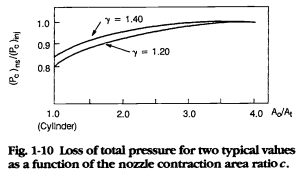


A recurrence relation is derived from equation 1-23 (below) in Huang, which gives the theoretical nozzle ratio at any section *x* between the nozzle inlet and nozzle exit as a function of the specific heat, $\gamma$, and mach at the section $M_x$. By using $\epsilon_c$ (i.e., $x = c$), we assume that the cross-sectional areas of the chamber and nozzle inlet are identical. It might be worth revisiting this assumption in the future.

$$ \frac{A_x}{A_t} =  \frac{1}{M_x} \sqrt{
    \left(\frac{1+\frac{\gamma - 1}{2}M_x}{\frac{\gamma+1}{2}}\right)^{\frac{\gamma+1}{\gamma-1}}}$$
    
Since extracting $M_x$ from this equation is algebraically intractable, the recurrence relation is used to iteratively seek a close approximation of the mach number that makes this equation valid for a given nozzle ratio.

In [4]:
#Iterative process to find mach number at the inlet.
#equation 1-23, huang
Mi_guess = .3 # a reasonable guess for mach number at inlet

def inlet_mach(guess):
    estimate = math.sqrt(
                         (2 * (1 + guess*(gam-1)/2)
                            / (gam+1)
                         ) ** ((gam+1)/(gam-1))
                        ) / epsilonc
    
    if abs(estimate - guess) < 0.0001:
        return estimate
    else:
        return inlet_mach(estimate)
    
Mi = inlet_mach(Mi_guess)

After determining the inlet mach number, several other parameters may also be obtained.

#### Pressures

The nozzle stagnation pressure can be found as a function of the injector pressure, gamma, and the inlet mach number:

$$ \frac{P_{c_{inj}}}{P_{c_{ns}}} = \frac{\big( 1 + \gamma M^2_i\big)}{\bigg( 1 + \frac{\gamma - 1}{2} M^2_i \bigg)^\frac{\gamma}{\gamma-1}} $$
(equation 1-14, huang)

Which may be used to find the nozzle pressure at the inlet:

$$ \frac{P_{inj}}{P_i} = 1 + \gamma M^2_i $$
(equation 1-15, huang)

Further, the pressure at the throat, also known as the critical pressure, may also be determined:

$$ \frac{P_t}{P_{c_{ns}}} = \bigg( \frac{2}{\gamma + 1} \bigg)^{\frac{\gamma}{\gamma - 1}} $$
(equation 1-16, huang)

It is important to note that past the throat of a de Laval nozzle, because the flow is moving faster than a pressure wave will propegate; a pressure wave due to an ambient pressure higher than that inside the nozzle will not occur. Because of this it is possible to expand the flow to pressures lower than ambient (or over-expand). Peak force production occurs when this pressure difference is negligible, and it is therefore important to consider at which altitude a nozzle should produce its peak force. It is uncommon for seperation to occur at the nozzle wall due to this overexpansion, but severe expansion angles or drastic over-expansion can lead to flow seperation.

#### Velocities

Velocity is obtained by the conversion of propellant enthalpy to motion, exit velocity is a function of the ratio of specific heats, nozzle pressure ratio, and chamber temperature, and is represented by,

$$ V_{e} = \sqrt{\frac{2g\gamma}{\gamma-1}R T_{c_{ns}}\bigg[1-\bigg(\frac{P_{e}}{P_{c_{ns}}}\bigg)^\frac{\gamma-1}{\gamma}}\bigg] $$
(1-18, huang)

The velocity at the throat is independent of pressure, and represents the speed of sound in the particular medium at the throat; it is a function of the ratio of specific heats and nozzle stagnation temperature,

$$ V_t = \sqrt{\frac{2g\gamma}{\gamma + 1}RT_{c_{ns}}} $$
(1-22, huang)

#### Mass flow rates

Mass flow rate will depend on the desired force for a nozzle design. In order to provide a specific force requirement, and given the above calculated exit velocities; a mass flow rate is calculated,

$$ F = \frac{\dot{w}}{g}V_e $$
(1-6, huang)

The propellant composition determines the specific mass flow rates of fuel and oxidizer. The fuel mass flow rate is calculated,

(mass percent formula for fuel * flow rate)

The difference between fuel and total flow rate is the remaining oxidizer flow rate,

(ox flow rate formula)

#### Temperature

The throat temperature is a function of either the throat pressure ratio, or throat velocity ratio and ratio of specific heats and is calculated,

$$ \frac{T_i}{T_t} = \bigg( \frac{P_i}{P_t} \bigg)^{\frac{\gamma - 1}{\gamma}} = \bigg( \frac{V_t}{V_i} \bigg)^{\gamma - 1} $$
(1-13, huang)

The exit temperature is calculated similarly,

$$ \frac{T_i}{T_e} = \bigg( \frac{P_i}{P_e} \bigg)^{\frac{\gamma - 1}{\gamma}} = \bigg( \frac{V_e}{V_i} \bigg)^{\gamma - 1} $$
(1-13, huang)

The inlet temperature is a function of the inlet mach number and ratio of specific heats,

$$ T_i = \frac{T_{c_{ns}}}{\big( 1+\frac{\gamma - 1}{2}M^2_i \big)}  $$
(table 1-1, huang)

#### Geometries

The throat area is critical to a choked flow. It is determined by first calculating the volume of gas according to the perfect gas law,

$$ 144 P_xV_x=RT_x $$
(1-9, huang)

which is then applied with the mass flow rate and throat velocity.

$$ \dot{W} = \frac{A_iv_i}{144V_i} = \frac{A_xv_x}{144V_x} $$
(1-11, huang)

Further, the expansion ratio is represented as a function of the exit ratio and ratio of specific heats,

$$ \epsilon = \frac{A_e}{A_t} = \frac{\bigg( \frac{2}{\gamma + 1} \bigg)^{\frac{1}{\gamma - 1}} \bigg[ \frac{P_{c_{ns}}}{P_e} \bigg]^{\frac{1}{\gamma}}}{\sqrt{ \frac{\gamma + 1}{\gamma - 1} \bigg[ 1 - \big( \frac{P_e}{P_{c_{ns}}} \big)^{\frac{\gamma - 1}{\gamma}} \bigg] }} $$
(1-20, huang)

which may be applied to the area ratio to determine the requisite exit area,

$$ A_e = A_t \frac{\bigg( \frac{2}{\gamma + 1} \bigg)^{\frac{1}{\gamma - 1}} \bigg[ \frac{P_{c_{ns}}}{P_e} \bigg]^{\frac{1}{\gamma}}}{\sqrt{ \frac{\gamma + 1}{\gamma - 1} \bigg[ 1 - \big( \frac{P_e}{P_{c_{ns}}} \big)^{\frac{\gamma - 1}{\gamma}} \bigg] }} $$
(1-20, huang)

Finally, the effective exhaust velocity is now calculated for engines operating at ambient pressures which are not equal to the exit pressure.

$$ c = v_e + A_e \big( P_e - P_a \big) \frac{g}{\dot{W}} $$
(1-8, huang)

In [5]:
# Pressures
Pcns     = Pcinj*(1+((gam-1)/2)*Mi**2)**(gam/(gam-1))/(1+gam*Mi**2)         #Nozzle stagnation pressure (1-14, huang)
Pi       = Pinj/(1+gam*Mi**2)                                               #Pressure at inlet          (1-15, huang)
Pt       = Pcns*(2/(gam+1))**(gam/(gam-1))                                  #Pressure at throat         (1-21, huang)

# Velocities
Ve       = math.sqrt(((2*g*gam)/(gam-1))*R*Tcns*(1-(Pe/Pi)**((gam-1)/gam))) #Velocity at exit           (1-18, huang)
Vt       = math.sqrt(((2*g*gam)/(gam+1))*R*Tcns)                            #Velocity at throat         (1-22, huang)

# Weight Flow Rates
wdot = mdot * 9.81 * 0.2248 # (kg/s * m/s^2) * (lbf/s)/(N/s)   #Propellant flow rate
wdotf    = 1/(1+rw)*wdot                                                    #Fuel mass flow rate
wdoto    = wdot-wdotf                                                       #Ox mass flow rate

# Temperatures
Tt       = Tcns*(Pt/Pcns)**((gam-1)/gam)                                    #Temperature at throat      (1-13, huang)
Ti       = Tcns/(1+.5*(gam-1)*Mi**2)                                        #Inlet temperature          (Tab. 1-1, huang)
Te       = Ti/(Pi/Pe)**((gam-1)/gam)                                        #Temperature at exit        (1-13, huang)

# Geometry
#Volume_t  = R*Tt/144/Pt                                                      #Gas volume at throat       (1-9,  huang)
#At2       = 144*wdot*Volume_t/Vt                                              #Area of throat             (1-11, huang)
# remarkably, the equation for At2 gives the same result as the theoretical equation for At
# so it doesn't really matter which we use
At       = wdot/Pcns * math.sqrt(R*Tcns/ (g*gam* (2/(gam+1))**((gam+1)/(gam-1))))
Wdot     = At*Pcns*math.sqrt(g*gam*(2/(gam+1))**((gam+1)/(gam-1))/R/Tcns)   #Theoretical weight flow    (1-19, huang)

epsilon  = (2/(gam+1))**(1/(gam-1)) * (Pcns/Pe)**(1/gam) / math.sqrt((gam+1)/
                        (gam-1)*(1-(Pe/Pcns)**(((gam-1)/gam))))              #Expansion ratio            (1-20, huang)
Ae       = At*epsilon                                                       #Area of exit               (1-20, huang)
c        = Ve+Ae*(Pe-Pa)*(g/wdot)                                           #Effective exhaust velocity (1-8,  huang)

thetaNr = math.pi/180*thetaN #rapid expansion angle in radians
thetar  = math.pi/180*theta #rapid contraction angle in radians

# Bottom up Calcs
F = wdot*Ve/g + (Pe - Pa)*Ae # calculate thrust in lbf

# THIS SECTION REQUIRES EXPLANATIONS PLS
where did the rest of these equations come from?

In [6]:
#Performance Parameters

Is    = F/wdot                                                      #Specific Impulse                (1-28,  huang)
Istc  = c/g                                                         #Thrust chamber specific impulse (1-31a, huang)
cstar = (math.sqrt(g*gam*R*Tcns)/gam
             /math.sqrt((2/(gam+1))**((gam+1)/(gam-1))))            #Characteristic Velocity         (1-32a, huang)
Cf    = (math.sqrt(2*gam**2/(gam-1)*(2/(gam+1))**((gam+1)/(gam-1))
             *(1-(Pe/Pcns)**((gam-1)/gam)))+epsilon*((Pe-Pa)/Pcns)) #Thrust Coefficient              (1-33a, huang)

In [7]:
#Thrust Chamber Layout

Vc = Lstar*At    #Chamber volume (4-4, huang)
Ac = epsilonc*At #Chamber cross sectional area (fig. 4-11, huang)
Lc = Lstar/Ac    #does not account for the converging part of combustion chamber use 4-5, huang instead

In [8]:
#Heat Transfer

Cplc   = rwfuel/100*CpFuel+(1-rwfuel/100)*CpH20                   #Coolant specific heat
Pr     = 4*gam/(9*gam-5)                                          #Prandtl number
mucc   = (46.6*10**-10)*M**0.5*Tcns                               #Viscosity in the combustion chamber
mut    = (46.6*10**-10)*M**0.5*Tt                                 #Viscosity in the throat
rlam   = Pr**0.5                                                  #Laminar flow local recovery factor
rturb  = Pr**0.33                                                 #Turbulent flow local recovery factor
Reffcc = ((1+rturb*((gam-1)/2)*Mi**2)/(1+((gam-1)/2)*Mi**2))
Refft  = ((1+rturb*((gam-1)/2))/(1+((gam-1)/2)))
Tawi   = edafilm*Tcns*Reffcc                                      #Adiabatic wall temperature at inlet
Tawt   = edafilm*Tcns*Refft                                       #Adiabatic wall temperature at throat
Tcc    = 9/5*(math.log(Pa/(Pi+DelPi))*Rgas/Hvapf+1/(Bpf*5/9))**-1 #Critical temperature of fuel coolant
Twc    = Tcc/nc                                                   #Maximum coolant wall temperature
Cpg    = gam*R/(gam-1)/J                                          #Specific heat at constant pressure
rt     = math.sqrt(At/math.pi)                                    #Radius of throat
re     = math.sqrt(Ae/math.pi)                                    #Radius of exit
rmean  = rt*(1.5+.382)/2                                          #Mean throat curvature
sigmat = (1/((.5*Twg/Tcns*(1+(gam-1)/2)+.5)**0.68                 #Correction factor for property variations across BL
             *(1+(gam+1)/2)**0.12))                               #specified at throat
sigmai = (1/((.5*Twg/Tcns*(1+(gam-1)/2*Mi**2)+.5)**0.68           #Correction factor for property variations across BL
             *(1+(gam+1)/2*Mi**2)**0.12))                         #specified at inlet
hg     = ((0.026/(2*rt)**0.2*(mucc**0.2*Cpg/Pr**0.6)
           *(Pcns*g/cstar)**0.8*(2*rt/rmean)**0.1)*sigmat)        #heat transfer coefficient at throat


Gc    = (hg/Cpvc/edac)/math.log((Tawt-Twc)/(Tawt-Twg)) #film cooling


q     = hg*(Tawt-Twg)                   #required heat flux
Tbulk = (Twc + Tci)/2                   #Coolant bulk temp
t     = k/q*(Twg-Twc)                   #Calculated Wall thickness for desired coolant wall temp
Qc    = (wdotf+Gc*Acool)*Cplc*(Twc-Tci) #Coolant capacity
hc    = q/(Twc-Tbulk)                   #Coolant side heat transfer coefficient
H     = 1/(1/hg+t/k+1/hc)               #Overall heat transfer coefficient

# THIS SECTION REQUIRES EXPLANATIONS PLS
where the hell do the equations come from?

In [9]:
#solve for minimum number of cooling channels to acheive appropriate cross sectional area,
#and the appropriate channel aspect ratio
def count_channels(guess, Re_num):
    bt    = (2*(rt+t)*math.pi/guess - t)          
    d     = 2 * ARhb * bt**2 / (ARhb+1) / bt 
    Vco   = Re_num / rhof / d * muf                 #Velocity for chosen Reynold's Number
    A_u   = (wdotf+Gc*Acool) / rhof / Vco     #unobstructed cross sectional area

    #find min number of channels for ideal ratio
    L = Symbol('L')
    estimate = round(solve(L*t+(A_u*L/ARhb)**0.5-(2*rt+2*t)*math.pi,L)[0])
    if guess == estimate:
        return guess
    else:
        return count_channels(max(estimate,1), Re_num)

def find_reynolds(guess):
    n = count_channels(1, guess)
    if n > 1:
        return guess, n
    else:
        return find_reynolds(guess + 50)

Re_est, n = find_reynolds(Remin)    

# I don't understand what this conditional is for! Don't we always want Re = Re_est?
if Re < Re_est:
    Re = Re_est

#cooling channel geometry
bt     = (2*rt+t)*math.pi/n-t              #base width at throat
be     = (2*re+t)*math.pi/n-t              #base width at exit
rccht  = bt/2                              #cooling channel effective radius at throat
rcche  = be/2                              #cooling channel effective radius at nozzle exit
d      = 2*ARhb*bt**2/(ARhb+1)/bt          #cooling channel hydraulic diameter
Vco    = Re/rhof/d*muf                    #velocity for chosen Reynold's Number
A_u    = (wdotf+Gc*Acool)/rhof/Vco        #unobstructed cross sectional area
A_ob   = n*(bt**2*(1-math.pi/4)+ARhb*bt*t) #total obstructed area
A_c    = A_u + A_ob                        #Total area for cooling channels to be used in parametric equations


#friction factor
# note, my change to a recursive function gives a result that differs after the 12th decimal place
def friction(guess):
    estimate = (2*math.log10(RA / 3.71 / d + 2.51 / Re / guess**0.5)
               )**(-2)
    estimate = (estimate + guess) / 2
    
    if abs(guess - estimate) < 0.000000000001:
        return estimate
    else:
        return friction(estimate)
    
if Re > 4000:
    f = friction(0.2) # starts with reasonable guess
else:
    f = 64/Re

#calculate pressure drop of a cooling channel
#to do this we must:
#calculate arc length of parametric equations (or use solidworks for now...)
#calculate reynolds number of passage
#calculate friction factor for the pipe use solver of darcy FF
#use this to determine holding tank pressure

In [10]:
#wall stresses

Ste    =(Pco-Pe)*rcche/t+E*a*q*t/2/(1-v)/k #combined tangential stress at nozzle exit
Stt    =(Pco-Pt)*rccht/t+E*a*q*t/2/(1-v)/k
Sce    =(Pco-Pe)*re/t+E*a*q*t/2/(1-v)/k    #maximum compressive stress as coaxial shell design

# My god these are unsightly expressions, pls explain
maybe a good idea to break these expressions up into functions so they can be explained term by term

(753.2315990292069, 1700.0)

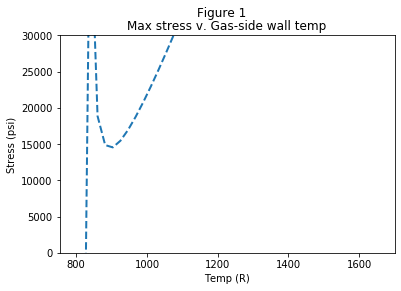

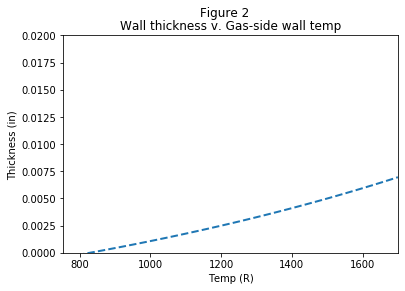

In [11]:
#heat transfer plots
#this needs to be revisited to ensure adjustments are being made for film cooling, the temperature doesnt seem to be graphing quite correctly

x = np.linspace(Tbulk,Twg)

#figure 1 Max stress v. Gas side wall temp
plt.figure(1)
line, = plt.plot(x,(Pco-Pt)*rccht/(k/((((0.026/(2*rt)**0.2*(mucc**0.2*Cpg/Pr**0.6)*(Pcns*g/cstar)**0.8*(2*rt/rmean)**0.1)*((1/((.5*x/Tcns*(1+(gam-1)/2)+.5)**0.68*(1+(gam+1)/2)**0.12)))))*(Tawt-x))*(x-Tcc))+E*a*q*(k/((((0.026/(2*rt)**0.2*(mucc**0.2*Cpg/Pr**0.6)*(Pcns*g/cstar)**0.8*(2*rt/rmean)**0.1)*((1/((.5*x/Tcns*(1+(gam-1)/2)+.5)**0.68*(1+(gam+1)/2)**0.12)))))*(Tawt-x))*(x-Tcc))/2/(1-v)/k, '--', linewidth=2)
plt.suptitle("Figure 1")
plt.title("Max stress v. Gas-side wall temp")
plt.xlabel("Temp (R)")
plt.ylabel("Stress (psi)")
plt.ylim([0,30000])
plt.xlim([Twc,Twg])

#figure 2 Wall thickness v. gas side wall temp
plt.figure(2)
line, = plt.plot(x,k/((((0.026/(2*rt)**0.2*(mucc**0.2*Cpg/Pr**0.6)*(Pcns*g/cstar)**0.8*(2*rt/rmean)**0.1)*((1/((.5*x/Tcns*(1+(gam-1)/2)+.5)**0.68*(1+(gam+1)/2)**0.12)))))*(Tawt-x))*(x-Tcc), '--', linewidth=2)
plt.suptitle("Figure 2")
plt.title("Wall thickness v. Gas-side wall temp")
plt.xlabel("Temp (R)")
plt.ylabel("Thickness (in)")
plt.ylim([0,0.020])
plt.xlim([Twc,Twg])

### Parametric Equations

Nozzle geometry is a critical parameter of any engine. Given an throat area, contraction ratio, expansion ratio, as well as the rapid expansion and contraction angles surrounding the throat; a unique set of parametric equations will justify the inner nozzle contour. Furthermore, given the wall thickness calculated as a function of the heat transfer properties of the throat; there exists a unique set of parametric equations justifying the remaining cooling channel geometries. These contours are generated such that the cross sectional area of the cooling channels normal to the surface of the rocket is a constant. Scaling functions may be applied, with an inversely proportional effect on the velocity of the fluid through the cooling channels. Left unchanged, the velocity of the coolant will be highest at the throat. The cross sectional area of the channels is certainly uniform, but the hydraulic diameter is decreasing as the cooling channels increase in aspect ratio (defined as the height of the rectangular duct divided by the base).

A designer may utilize these parametric equations by importing them into computer aided drafting (CAD) software, and rotating the resulting contours about the y axis. The particular proceedure of such a rotation in any particular CAD software is beyond the scope of this document.

# For the love of christ, where were these equations born?
I have taken the liberty of simplifying these expressions and removing many reduncancies.

In [12]:
rcc = math.sqrt((At*epsilonc)/math.pi)
#Parametric Equations

#calculate parameters
tout   = 2*t # calculate a better outer thickness or place in input parameters

# Calculated constants:
A3 = 1.382*rt
A4 = 0.382*rt

A1 = 1/math.tan(thetaNr) / (2*(rt - A4*(1 - math.cos(thetaNr))))
X1 = A3 - A4*math.cos(thetaNr)
A2 = A1*(rt + A4*(1 - math.cos(thetaNr)))**2 - A4*math.sin(thetaNr)
Rbell = t

A5 = 2.5*rt
A6 = -1.5*rt

p1 = A5 + A6*math.cos(thetar)
p2 = rcc + A6*(1 - math.cos(thetar))

A20 = math.tan(thetar)
A7  = -1/A20
A17 = -A7 * p1
A8  = A17 + A6*math.sin(thetar)
A9  = -A6
A10 = A9
A11 = A7 * (rcc - rt*(4 - 3*math.cos(thetar))) - 3*rt*math.sin(thetar)
A12 = 1/(4*A1**2)
A13 = math.cos(thetar)*t
A14 = math.sin(thetar)*t
A15 = A_c / math.pi
A16 = math.cos(thetar)*A15
A18 = A6 * math.sin(thetar)
A19 = A15 * math.cos(thetar)
A21 = math.cos(thetar)*tout
A22 = math.sin(thetar)*tout

In [13]:
print("---------------------")
print("Parametric Equations:")
print("---------------------\n")

#Print internal contour equations
print("-----------------")
print("Internal Contour:")
print("-----------------\n")
print("Bell")
print("x(t):")
print(" t")
print("y(t):")
print(" %f * t^2 - %f" % (A1,A2) )
print("Parameters:" )
print("t1:")
print(" %f" % X1 )
print("t2:")
print(" %f\n" % (re-0.0001) )

print("Throat, rapid expansion")
print("x(t):")
print(" %f * (1- (.382/1.382) * cos(t*3.14159/180))" % A3 )
print("y(t):")
print(" %f * sin(t*3.14159/180)" % A4 )
print("Parameters:" )
print("t1:")
print(" 0.001" )
print("t2:")
print(" %f\n" % (thetaN-0.001) )

print("Throat, rapid contraction")
print("x(t):")
print(" %f * (1 - 0.6 * cos(t*3.14159/180))" % A5 )
print("y(t):")
print(" %f * sin(t*3.14159/180)" % A6 )
print("Parameters:" )
print("t1:")
print(" 0.001" )
print("t2:")
print(" %f\n" % (theta-0.001) )

print("Linear contraction")
print("x(t):")
print(" t")
print("y(t):")
print(" %f * t + %f" % (A7,A8))
print("Parameters:" )
print("t1:")
print(" %f" % (p1+0.0001) )
print("t2:")
print(" %f\n" % (p2-0.0001) )

print("Inlet")
print("x(t):")
print(" %f - %f * (1 - cos(t*3.14159/180))" % (rcc,A9))
print("y(t):")
print(" %f * sin(t*3.14159/180) + %f" % (A10,A11))
print("Parameters:")
print("t1:")
print(" 0.001" )
print("t2:")
print(" %f\n" % (theta-0.0001) )

#Print inner cooling channel wall equations
print("-----------------------")
print("Cooling Channel, inner:" )
print("-----------------------\n")
print("Bell")
print("x(t):")
print(" t + ( %f * t / ( t^2 + %f )^0.5)" % (t,A12))
print("y(t):")
print(" %f *t^2 - %f + ( %f / ( %f *( t^2 + %f )^0.5))" % (A1,A2,-t,2*A1,A12))
print("Parameters:")
print("t1:")
print(" %f" % (X1+0.0001) )
print("t2:")
print(" %f\n" % (re-0.0001) )

print("Rapid Expansion")
print("x(t):")
print(" %f * (1- (.382/1.382) * cos(t*3.14159/180)) + ( %f * cos(t*3.14159/180))" % (A3,t) )
print("y(t):")
print(" %f * sin(t*3.14159/180) + (%f *sin(t*3.14159/180))" % (A4,-t) )
print("Parameters:" )
print("t1:")
print(" 0.001" )
print("t2:")
print(" %f\n" % (thetaN-0.001) )

print("Rapid Contraction")
print("x(t):")
print(" %f * (1 - 0.6 * cos(t*3.14159/180)) + ( %f * cos(t*3.14159/180))" % (A5,t) )
print("y(t):")
print(" %f * sin(t*3.14159/180) + (%f *sin(t*3.14159/180))" % (A6,t) )
print("Parameters:" )
print("t1:")
print(" 0.001" )
print("t2:")
print(" %f\n" % (theta-0.001) )

print("Linear contraction")
print("x(t):")
print(" t + %f" % A13)
print("y(t):")
print(" %f * t + %f" % (A7,A8+A14))
print("Parameters:" )
print("t1:")
print(" %f" % (p1+0.0001) )
print("t2:")
print(" %f\n" % (p2-0.0001) )

print("Inlet")
print("x(t):")
print(" %f - %f * (1 - cos(t*3.14159/180)) + ( %f * cos(t*3.14159/180))" % (rcc,A9,t))
print("y(t):")
print(" %f * sin(t*3.14159/180) + %f + (%f *sin(t*3.14159/180))" % (A10,A11,t))
print("Parameters:")
print("t1:")
print(" 0.001" )
print("t2:")
print(" %f\n" % (theta-0.0001) )

#Print outter cooling channel wall equations
print("-----------------------")
print("Cooling Channel, outer:" )
print("-----------------------\n")

print("Bell")
print("x(t):")
print(" t + ( %f * t / ( t^2 + %f )^0.5) + ( t / ( t^2 + %f )^0.5) * ( -t + (t^2 + %f * sin(2*3.14159 - arctan(%f*t)))^(.5)) / (sin(2*3.14159-arctan(%f*t)))" % (t,A12,A12,A15,-2*A1,-2*A1))
print("y(t):")
print(" %f *t^2 - %f + ( %f / ( %f *( t^2 + %f )^0.5)) + ( 1 / ( %f * (t^2+ %f )^0.5)) * ( -t + ( t^2 + %f * sin(2*3.14159-arctan(%f*t)))^0.5) / ( sin(2*3.14159 - arctan(%f*t)))" % (A1,A2,-t,2*A1,A12,-2*A1,A12,A15,-2*A1,-2*A1))
print("Parameters:")
print("t1:")
print(" %f" % (X1+0.0001) )
print("t2:")
print(" %f\n" % (re-0.0001) )

print("Rapid Expansion")
print("x(t):")
print(" %f * (1- (.382/1.382) * cos(t*3.14159/180)) + ( %f * cos(t*3.14159/180)) + ( -( %f * ( 1 - (0.382)/(1.382) * cos(t*3.14159/180) ) ) + (( %f * (1 - (0.382)/(1.382) * cos(t*3.14159/180) ))^2 + %f * cos(t*3.14159/180))^0.5)" % (A3,t,A3,A3,A15)     )
print("y(t):")
print(" %f * sin(t*3.14159/180) + (%f *sin(t*3.14159/180)) + ( -( %f * ( 1 - (0.382)/(1.382) * cos(t*3.14159/180) ) ) + ( (%f * ( 1 - (0.382)/(1.382) * cos(t*3.14159/180) ) )^2 + %f * cos(t*3.14159/180) )^0.5 ) * ( -tan(t*3.14159/180) )" % (A4,-t,A3,A3,A15)     )
print("Parameters:" )
print("t1:")
print(" 0.001" )
print("t2:")
print(" %f\n" % (thetaN-0.001) )

print("Rapid Contraction")
print("x(t):")
print(" %f * (1 - 0.6 * cos(t*3.14159/180)) + ( %f * cos(t*3.14159/180)) + ( -( %f * ( 1 - 0.6 * cos(t*3.14159/180) ) ) + ( ( %f * ( 1 - 0.6 * cos(t*3.14159/180) ) )^2 + ( %f ) * cos(t*3.14159/180) )^0.5 )" % (A5,t,A5,A5,A15)     )
print("y(t):")
print(" %f * sin(t*3.14159/180) + (%f *sin(t*3.14159/180)) + ( -( %f * ( 1 - 0.6 * cos(t*3.14159/180) ) ) + ( ( %f * ( 1 - 0.6 * cos(t*3.14159/180) ) )^2 + %f * cos(t*3.14159/180) )^0.5 ) * ( tan(t*3.14159/180) )"             % (A6,t,A5,A5,A15)     )
print("Parameters:" )
print("t1:")
print(" 0.001" )
print("t2:")
print(" %f\n" % (theta-0.001) )

print("Linear contraction")
print("x(t):")
print(" t + %f + ( -t + ( t^2 + %f )^0.5 )" % (A13,A16))
print("y(t):")
print(" %f *t + %f + %f + ( -t + ( t^2 + %f )^0.5 ) * ( %f ) + ( %f )" % (A7,A17,A18,A19,A20,A14))
print("Parameters:" )
print("t1:")
print(" %f" % (p1+0.0001) )
print("t2:")
print(" %f\n" % (p2-0.0001) )

print("Inlet")
print("x(t):")
print(" %f - %f * (1 - cos(t*3.14159/180)) + ( %f * cos(t*3.14159/180)) + ( -( %f - %f * ( 1 - cos(t*3.14159/180) ) ) + ( ( %f - %f * ( 1 - cos(t*3.14159/180)))^2 + %f * cos(t*3.14159/180) )^0.5 )" % (rcc,A9,t,rcc,A9,rcc,A9,A15))
print("y(t):")
print(" %f * sin(t*3.14159/180) + %f + ( %f * sin(t*3.14159/180) ) + ( -( %f - %f * ( 1 - cos(t*3.14159/180) ) ) + ( ( %f - %f * ( 1 - cos(t*3.14159/180) ) )^2 + %f * cos(t*3.14159/180) )^0.5 ) * tan(t*3.14159/180)" % (A10,A11,t,rcc,A10,rcc,A10,A15))
print("Parameters:")
print("t1:")
print(" 0.001" )
print("t2:")
print(" %f\n" % (theta-0.0001) )

#print outter nozzle surface equations
print("----------------------")
print("Nozzle surface, outer:" )
print("----------------------\n")

print("Bell")
print("x(t):")
print(" t + ( %f * t / ( t^2 + %f )^0.5 ) + ( t / ( t^2 + %f )^0.5 ) * ( -t + ( t^2 + %f * sin(2*3.14159 - arctan(%f*t)) )^0.5 ) / ( sin(2*3.14159 - arctan(%f*t)) ) + ( %f * t / ( t^2 + %f )^0.5 )" % (t,A12,A12,A15,-2*A1,-2*A1,tout,A12))
print("y(t):")
print(" %f *t^2 - %f + ( %f / ( %f *( t^2 + %f )^0.5)) + ( 1 / ( %f * ( t^2+ %f )^0.5 ) ) * ( -t + ( t^2 + %f * sin(2*3.14159 - arctan(%f*t)) )^0.5 ) / ( sin(2*3.14159 - arctan(%f*t)) ) + ( %f / ( %f * ( t^2 + %f )^0.5 ) )" % (A1,A2,-t,2*A1,A12,-2*A1,A12,A15,-2*A1,-2*A1,-tout,2*A1,A12))
print("Parameters:")
print("t1:")
print(" %f" % (X1+0.0001) )
print("t2:")
print(" %f\n" % (re-0.0001) )

print("Rapid Expansion")
print("x(t):")
print(" %f * ( 1- (.382/1.382) * cos(t*3.14159/180) ) + ( %f * cos(t*3.14159/180) ) + ( -( %f * ( 1 - (0.382)/(1.382) * cos(t*3.14159/180) ) ) + ( ( %f * ( 1 - (0.382)/(1.382) * cos(t*3.14159/180) ) )^2 + %f * cos(t*3.14159/180) )^0.5 ) + ( %f * cos(t*3.14159/180) )" % (A3,t,A3,A3,A15,tout)     )
print("y(t):")
print(" %f * sin(t*3.14159/180) + ( %f *sin(t*3.14159/180) ) + ( -( %f * ( 1 - (0.382)/(1.382) * cos(t*3.14159/180) ) ) + ( ( %f * ( 1 - (0.382)/(1.382) * cos(t*3.14159/180) ) )^2 + %f * cos(t*3.14159/180) )^0.5 ) * ( -tan(t*3.14159/180) ) + ( %f * sin(t*3.14159/180) )" % (A4,-t,A3,A3,A15,-tout)     )
print("Parameters:" )
print("t1:")
print(" 0.001" )
print("t2:")
print(" %f\n" % (thetaN-0.001) )

print("Rapid Contraction")
print("x(t):")
print(" %f * ( 1 - 0.6 * cos(t*3.14159/180) ) + ( %f * cos(t*3.14159/180) ) + ( -( %f * ( 1 - 0.6 * cos(t*3.14159/180) ) ) + ( ( %f * ( 1 - 0.6 * cos(t*3.14159/180) ) )^2 + ( %f ) * cos(t*3.14159/180) )^0.5 ) + ( %f * cos(t*3.14159/180) )" % (A5,t,A5,A5,A15,tout)     )
print("y(t):")
print(" %f * sin(t*3.14159/180) + ( %f *sin(t*3.14159/180) ) + ( -( %f * ( 1 - 0.6 * cos(t*3.14159/180) ) ) + ( ( %f * ( 1 - 0.6 * cos(t*3.14159/180) ) )^2 + %f * cos(t*3.14159/180) )^0.5 ) * ( tan(t*3.14159/180) ) + ( %f *sin(t*3.14159/180) )"             % (A6,t,A5,A5,A15,tout)     )
print("Parameters:" )
print("t1:")
print(" 0.001" )
print("t2:")
print(" %f\n" % (theta-0.001) )

print("Linear contraction")
print("x(t):")
print(" t + %f + ( -t + ( t^2 + %f )^0.5 ) + %f" % (A13,A16,A21))
print("y(t):")
print(" %f *t + %f + %f + ( -t + ( t^2 + %f )^0.5 ) * ( %f ) + ( %f ) + ( %f )" % (A7,A17,A18,A19,A20,A14,A22))
print("Parameters:" )
print("t1:")
print(" %f" % (p1+0.0001) )
print("t2:")
print(" %f\n" % (p2-0.0001) )

print("Inlet")
print("x(t):")
print(" %f - %f * (1 - cos(t*3.14159/180) ) + ( %f * cos(t*3.14159/180) ) + ( -( %f - %f * ( 1 - cos(t*3.14159/180) ) ) + ( ( %f - %f * ( 1 - cos(t*3.14159/180) ) )^2 + %f * cos(t*3.14159/180) )^0.5 ) + ( %f * cos(t*3.14159/180) )" % (rcc,A9,t,rcc,A9,rcc,A9,A15,tout))
print("y(t):")
print(" %f * sin(t*3.14159/180) + %f + ( %f * sin(t*3.14159/180) ) + ( -( %f - %f * ( 1 - cos(t*3.14159/180) ) ) + ( ( %f - %f * ( 1 - cos(t*3.14159/180) ) )^2 + %f * cos(t*3.14159/180) )^0.5 ) * tan(t*3.14159/180) + ( %f * sin(t*3.14159/180) )" % (A10,A11,t,rcc,A10,rcc,A10,A15,tout))
print("Parameters:")
print("t1:")
print(" 0.001"  )
print("t2:")
print(" %f\n" % (theta-0.0001) )

---------------------
Parametric Equations:
---------------------

-----------------
Internal Contour:
-----------------

Bell
x(t):
 t
y(t):
 0.593382 * t^2 - 0.404090
Parameters:
t1:
 1.054937
t2:
 2.823923

Throat, rapid expansion
x(t):
 1.311217 * (1- (.382/1.382) * cos(t*3.14159/180))
y(t):
 0.362435 * sin(t*3.14159/180)
Parameters:
t1:
 0.001
t2:
 44.999000

Throat, rapid contraction
x(t):
 2.371955 * (1 - 0.6 * cos(t*3.14159/180))
y(t):
 -1.423173 * sin(t*3.14159/180)
Parameters:
t1:
 0.001
t2:
 44.999000

Linear contraction
x(t):
 t
y(t):
 -1.000000 * t + 0.359284
Parameters:
t1:
 1.365720
t2:
 1.704603

Inlet
x(t):
 2.121541 - 1.423173 * (1 - cos(t*3.14159/180))
y(t):
 1.423173 * sin(t*3.14159/180) + -2.351754
Parameters:
t1:
 0.001
t2:
 44.999900

-----------------------
Cooling Channel, inner:
-----------------------

Bell
x(t):
 t + ( 0.007553 * t / ( t^2 + 0.710021 )^0.5)
y(t):
 0.593382 *t^2 - 0.404090 + ( -0.007553 / ( 1.186764 *( t^2 + 0.710021 )^0.5))
Parameters:
t1:
 

### Finite Element Analysis

The flow properties at any axial location of a rocket nozzle are modeled as an ideal gas. Therefore, if the particular geometry of the nozzle is known, then the properties within a finite element of the flow may be known. By determining the flow properties of the gas, a heat transfer coefficient may also be found, as well as the heat flux into any particular channel. By assuming that the heat flux into the fluid is equal to the heat flux through the nozzle wall, it may be determined whether a particular finite volume of coolant aquires enough heat to achieve a phase change, resulting in nucleate boiling when the coolant pressures are low enough for that phase change to be from a liquid to a gas.

In some cases; where the pressure is high enough, a coolant super critical state may be achieved. In such cases, there may be advantages to allowing a phase change. It is; however, not advantageous to allow nucleate boiling, which would result in an insulative gas layer forming between the wall and the coolant, quickly leading to engine failure.

The scope of this analysis is solely to determine the amount of heat accepted by a finite volume of fluid and produce a reasonable guess as to the phase state of the coolant at the exit of the convergent section of the nozzle. This will allow for a designer to alter their original assumptions about the converging angle of the nozzle, the rapid expansion angle of the nozzle, or the length of the combustion chamber.

In general, a decrease in the surface area of the nozzle will result in less heat being transfered into the coolant. Therefore, heat transfer may be decreased by an increase of either the convergence angle or the rapid expansion angle of the nozzle. Furthermore, heat transfer may be decreased by shortening the combustion chamber. Typically, these changes will result in lower nozzle efficiencies.

Coolant capacity may be increased by either the dilution of the fuel with water (in the case that the fuel is aqueous), or by increasing the mass flow rate of fuel in the nozzle. The latter is achievable by increasing the desired force of a nozzle, or by increasing the amount of film cooled surface area within the nozzle. Coefficients modifiying the adiabadic wall temperature of the flow due to the addition of film cooling should be determined by measurements performed in testing.

Keep in mind while reading this section and examining the graphs it produces that the chamber is to the right and the exit is to the left (i.e., x=0 is the exit, and x=6 is near the injector).

In [14]:
#Populate properties along the full length of nozzle, piecewise
x  = [0] # x position array
dx = 0.01 # change in x position

# need these values for rx in a couple logic blocks
yr = Symbol("yr")
m = A20
b = A5 + A6*math.cos(thetar) - m*(A1*re**2 - A2 + A9*math.sin(thetar))
xcenter = A1*re**2 - (A2 + A11)
ycenter = rcc + A6

#intialize arrays for properies
ARatioSub = [] #subsonic area ratio for lookup matrix
ARatioSup = [] #supersonic area ratio for lookup matrix
rx        = [] #radius
Ax        = [] #area
AR        = [] #actual area ratio of nozzle
Px        = [] #pressure
Tx        = [] #temperature
Vx        = [] #velocity
ax        = [] #local sonic velocity
Mx        = [] #local mach number
sigmax    = [] #local correction factor for property variations across boundary layer
hgx       = [] #local gas side heat transfer coefficient
Tawx      = [] #local adiabadic wall temperature of gas
qx        = [] #heat flux through chamber wall

res     = 1000 # resolution of mach lookup matrix

MachSub = np.linspace(1/res,1,num=res)
MachSup = np.linspace(1+1/res,10,num=res*9)

#build AR matricies
for Machx in MachSub:
    ARatioSub.append(1/Machx*(((1+((gam-1)/2)*Machx**2)/(1+((gam-1)/2)))**((gam+1)/(gam-1)))**0.5)

for Machx in MachSup:
    ARatioSup.append(1/Machx*(((1+((gam-1)/2)*Machx**2)/(1+((gam-1)/2)))**((gam+1)/(gam-1)))**0.5)

# match mach number to current area ratio
# Ax[i]/At -> eps_x
# ARatioSup or Sub -> ratio_list
# < or > -> relation
def get_currentAR(eps_x, ratio_list, relation):
    for j, ratio in enumerate(ratio_list):
        if not relation(ratio, eps_x):
            return ratio, j

# i think the sequential logic in this block looks sketchy
# think harder about whether i-th elements should reference other i-th elements or (i-1)-th elements instead
for i in range(math.ceil(((A1*re**2 - (A2 + A11)) / dx))):
    # there is a supersonic regime during expansion and subsonic regime during compression
    if x[i] < (A1*re**2 - A1*X1**2) + A4*sin(thetaNr):
        macharray = MachSup
        ratioarray = ARatioSup
        relation = operator.lt
    elif x[i] < A1*re**2 - (A2 + A11):
        macharray = MachSub
        ratioarray = ARatioSub
        relation = operator.gt
    
    # radius depends on axial position along nozzle
    # unsolved mystery: how do we know which solution to each quadratic is appropriate one?
    # expansion
    if x[i] < A1*re**2 - A1*X1**2:
        rx.append(((A1*re**2 - x[i]) / A1)**.5)
    # throat
    elif x[i] < A1*re**2 - A1*X1**2 + A4*sin(thetaNr):
        rx.append(solve((x[i] - (A1*re**2 - A2))**2 + (yr - A3)**2 - A4**2, yr)[0])
    # compression
    elif x[i] < A1*re**2 - A1*X1**2 + A4*sin(thetaNr) + A9*sin(thetar):
        rx.append(solve((x[i] - (A1*re**2 - A2))**2 + (yr - A5)**2 - A9**2, yr)[0])
    # chamber
    elif x[i] < A1*re**2 - (A7*p2 + A2 + A8):
        rx.append(m*x[i] + b)
    # near injector
    elif x[i] < A1*re**2 - (A2 + A11):
        rx.append(solve((x[i] - xcenter)**2 + (yr - ycenter)**2 - A9**2, yr)[1])
    
    x.append(x[i] + dx) # recall that this is one index ahead of the rest
    Ax.append(math.pi*rx[i]**2)
    AR.append(Ax[i] / At)
    
    Volumex = Ax[i]*dx
    Volumet = At*dx
    
    # match mach number to current area ratio
    currentAR, j = get_currentAR(Ax[i]/At, ratioarray, relation)
    
    y1 = macharray[j]
    y2 = macharray[j-1]
    x1 = ratioarray[j]
    x2 = ratioarray[j-1]
    
    Mx.append((Ax[i]/At - x1)*(y2 - y1) / (x2 - x1) + y1)
    Px.append(Pcns / (1 + 0.5*(gam - 1)*Mx[i]**2)**(gam/(gam-1)))
    Tx.append(Tcns / (Pcns/Px[i])**((gam-1)/gam))
    Vx.append(math.sqrt(2*g*gam / (gam-1) *R*Tcns*(1 - (Px[i]/Pcns)**((gam-1)/gam))))
    ax.append(math.sqrt(g*gam*R*Tx[i]))
    sigmax.append((1/((.5*Twg/Tcns*(1+(gam-1)/2*Mx[i]**2)+.5)**0.68*(1+(gam+1)/2*Mx[i]**2)**0.12)))
    hgx.append(((0.026/(2*rt)**0.2*(mucc**0.2*Cpg/Pr**0.6)*(Pcns*g/cstar)**0.8*(2*rt/rmean)**0.1)*(At/Ax[i])**0.9*sigmax[i]))
    Tawx.append(edafilm*Tcns*((1+rturb*((gam-1)/2)*Mx[i]**2)/(1+((gam-1)/2)*Mx[i]**2)))
    qx.append(hgx[i]*(Tawx[i]-Twg))

del x[-1] # we added an extra x value we don't need

(0, 7)

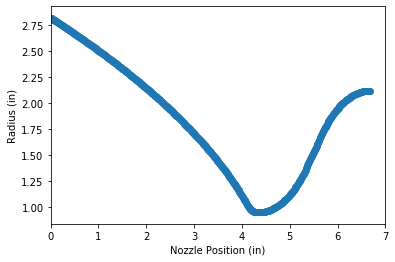

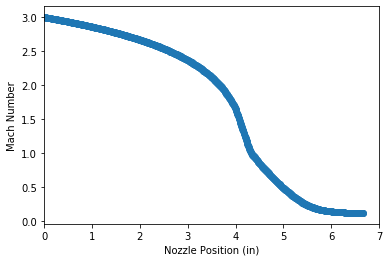

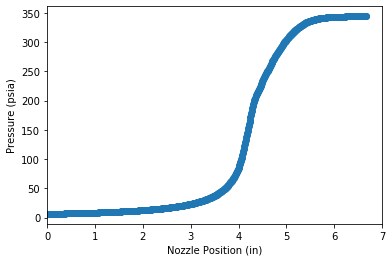

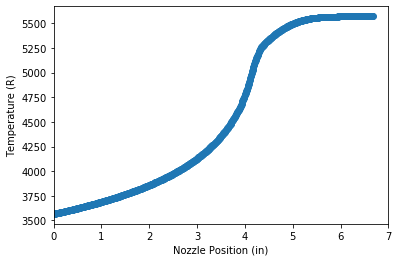

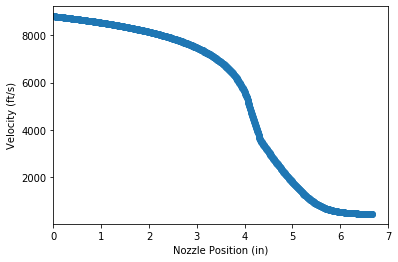

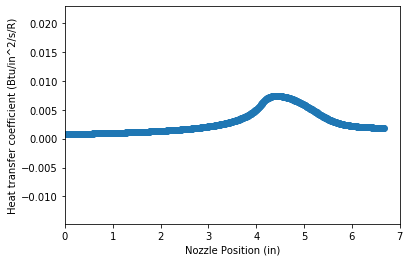

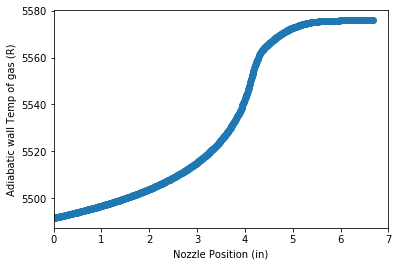

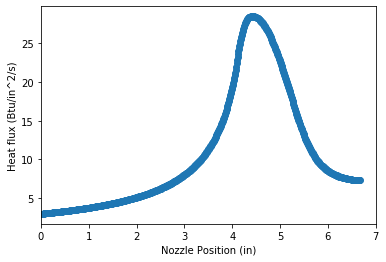

In [15]:
# Plots of properties along the length of the nozzle

plt.figure(0)
plt.scatter(x,rx)
plt.xlabel('Nozzle Position (in)')
plt.ylabel('Radius (in)')
plt.xlim([0,math.ceil(max(x))])

plt.figure(1)
plt.scatter(x,Mx)
plt.xlabel('Nozzle Position (in)')
plt.ylabel('Mach Number')
plt.xlim([0,math.ceil(max(x))])

plt.figure(2)
plt.scatter(x,Px)
plt.xlabel('Nozzle Position (in)')
plt.ylabel('Pressure (psia)')
plt.xlim([0,math.ceil(max(x))])

plt.figure(3)
plt.scatter(x,Tx)
plt.xlabel('Nozzle Position (in)')
plt.ylabel('Temperature (R)')
plt.xlim([0,math.ceil(max(x))])

plt.figure(4)
plt.scatter(x,Vx)
plt.xlabel('Nozzle Position (in)')
plt.ylabel('Velocity (ft/s)')
plt.xlim([0,math.ceil(max(x))])

plt.figure(5)
plt.scatter(x,hgx)
plt.xlabel('Nozzle Position (in)')
plt.ylabel('Heat transfer coefficient (Btu/in^2/s/R)')
plt.xlim([0,math.ceil(max(x))])

plt.figure(6)
plt.scatter(x,Tawx)
plt.xlabel('Nozzle Position (in)')
plt.ylabel('Adiabatic wall Temp of gas (R)')
plt.xlim([0,math.ceil(max(x))])

plt.figure(7)
plt.scatter(x,qx)
plt.xlabel('Nozzle Position (in)')
plt.ylabel('Heat flux (Btu/in^2/s)')
plt.xlim([0,math.ceil(max(x))])



In [16]:
#Determine heat added to fuel
Aqx=[]
Qx =[]
lenCC = 0

for j, rx_j in enumerate(rx):
    if j==0: continue # it is a mystery to me why the previous script started at j=1
    distance = math.sqrt(dx**2 + (rx[j-1] - rx_j)**2)
    Aqx.append(distance * math.pi * (rx[j-1] + rx_j))
    Qx.append(Aqx[j-1] * (qx[j-1] + qx[j]) * .5)
    lenCC += distance #total length of channel
Qtot = sum(Qx)

In [17]:
#pressure loss in cooling passage
#determine a pressure loss calculated from finite element analysis rather than worst case friction factor at the throat
delP = f * rhof / 2 * Vco**2 / d * (lenCC + Lc)

In [18]:
#this should probably move to its own page soon
#calculating pressure drops and orofice sizes for injector
#this a hack to make DelPinj > 0
delP = DelPi
DelPinj = Pco - delP - Pcinj
Afuel = wdotf/Cd/Ninj/math.sqrt(2/rhof*DelPinj)
Aox   = wdoto/Cd/Ninj/math.sqrt(2/rhoo*DelPinj)

Dfuel = math.sqrt(Afuel/math.pi)*2
Dox   = math.sqrt(Aox/math.pi)*2

vfuel = wdotf/Ninj/Afuel
vox   = wdoto/Ninj/Aox

gammaf = math.degrees(math.asin(wdoto*vox/wdotf/vfuel*math.sin(math.radians(gammao))))

In [19]:
# Output:
print("-------"  )
print("Inputs:"  )
print("-------\n")

print("CEArun:")
print("Molecular Weight,              M  (lb/lb-mol):     %.2f"   % M      )
print("Weight mixture ratio,          rw            :     %.2f"   % rw     )
print("Fuel mixture percentage,       rwfuel        :     %.2f"   % rwfuel )
print("Nozzle stagnation temperature, Tcns   (deg R):     %.2f"   % Tcns   )
print("Throat Temperature,            Tt     (deg R):     %.2f"   % Tt     )
print("Specific heat ratio,           gamma         :     %.4f\n" % gam    )

print("Optimization Parameters:")
print("Force,                         F        (lbf):     %.2f"   % F      )
print("Exit Pressure,                 Pe  (lbf/in^2):     %.2f"   % Pe     )
print("Pressure at injector,          Pinj (lb/in^2):     %.2f\n" % Pinj   )

print("Atmospheric Parameters:")
print("Ambient Pressure,              Pa  (lbf/in^2):     %.2f"   % Pa     )
print("Ambient temperature,           Tamb   (deg R):     %.2f\n" % Tamb   )

print("Geometry Parameters:")
print("Cooling channel aspect ratio at throat: %.2f" % ARhb )
print("Discharge Coefficient: %.2f" % Cd )
print("Contraction ratio: %.2f" % epsilonc )
print("Desired injector angle for oxidizer (deg): %.2f" % gammao )
print("Characteristic Chamber Length, L* (in): %.2f" % Lstar )
print("Number of injector doublets: %.2f" % Ninj )
print("Rapid contraction angle (deg): %.2f" % theta )
print("Rapid expansion angle (deg): %.2f\n" % thetaN )

print("-------"  )
print("Outputs"  )
print("-------\n")

print("Pressures:")
print("Total Chamber,  Pcinj (psi):     %.2f"   % Pcinj )
print("Stagnation,     Pcns  (psi):     %.2f"   % Pcns  )
print("Inlet,          Pi    (psi):     %.2f"   % Pi    )
print("Throat,         Pt    (psi):     %.2f\n" % Pt    )

print("Velocities:")
print("Throat,         Vt (ft/sec):     %.2f"   % Vt    )
print("Exit,           Ve (ft/sec):     %.2f"   % Ve    )
print("Effective,      c  (ft/sec):     %.2f\n" % c     )

print("Mass Flow Rates:")
print("Total,          wdot  (lb/sec):  %.2f"   % wdot  )
print("Fuel,           wdotf (lb/sec):  %.2f"   % wdotf )
print("Oxidizer,       wdoto (lb/sec):  %.2f"   % wdoto )
print("Theoretical,    Wdot  (lb/sec):  %.2f\n" % Wdot  )

print("Temperatures:")
print("Fuel (holding), Tci  (R):        %.2f"   % Tci   )
print("Stagnation,     Tcns (R):        %.2f"   % Tcns  )
print("Inlet,          Ti   (R):        %.2f\n" % Ti    )

print("Geometries:")
print("Expansion Ratio: %.2f" % epsilon)

print("Mach Number at inlet: %.2f" % Mi)

#Print Performance Parameters

print("Specific Impulse,                Is   (lb s/lb):  %.2f" % Is    )
print("Thrust Chamber specific impulse, Istc (lb s/lb):  %.2f" % Istc  )
print("Characteristic Velocity,         c*   (ft/s):     %.2f" % cstar )
print("Thrust Coefficient,              Cf:              %.2f" % Cf    )

#print thrust chamber layout

print("Chamber Volume,               Vc (in^3):  %.2f" % Vc)
print("Chamber Cross Sectional Area, Ac (in^2):  %.2f" % Ac)
print("Chamber Length,               Lc (in):    %.2f" % Lc)

#print heat transfer
print("Coolant Specific Heat,                                         Cplc:   %.2f" % Cplc)
print("Prandtl Number,                                                Pr:     %.2f" % Pr)
print("Viscosity in combustion chamber,                               mucc:   %.8f" % mucc)
print("Viscosity in throat,                                           mut:    %.8f" % mut)
print("Laminar Flow Local Recovery Factor,                            rlam:   %.2f" % rlam)
print("Turbulent Flow Local Recovery Factor,                          rturb:  %.2f" % rturb)
print("Effective Combustion Chamber Recovery Factor,                  Reffcc: %.2f" % Reffcc)
print("Effective Throat Recovery Factor,                              Refft:  %.2f" % Refft)
print("Adiabatic wall temperature at inlet,                           Tawi:   %.2f" % Tawi)
print("Adiabatic wall temperature at throat,                          Tawt:   %.2f" % Tawt)
print("Throat radius,                                                 rt:     %.3f" % rt)
print("Exit radius,                                                   re:     %.3f" % re)
print("Mean throat curvature,                                         rmean:  %.3f" % rmean)
print("Correction factor for property variations across BL at throat, sigmat: %.2f" % sigmat)
print("Correction factor for property variations across BL at inlet,  sigmai: %.2f" % sigmai)
print("Specific heat at constant pressure,                            Cpg:    %.5f" % Cpg)
print("Heat transfer coefficient at throat,                           hg:     %.5f" % hg)
print("Required heat flux,                                            q:      %.2f" % q)
print("Critical temperature of coolant,                               Tcc:    %.2f" % Tcc)
print("Coolant capacity,                                              Qc:     %.2f" % Qc)
print("Coolant wall temperature,                                      Twc     %.2f" % Twc)
print("Coolant bulk temperature,                                      Tbulk:  %.2f" % Tbulk)
print("Wall thickness,                                                t:      %.5f" % t)
print("Coolant side heat transfer coefficient,                        hc:     %.5f" % hc)
print("Overall heat transfer coefficient,                             H:      %.5f" % H)
print("Film-Coolant flowrate per unit area of cooled wall, lb/in^2/s  Gc:     %.3f" % Gc)

#print cooling channel geometry

print("Fuel viscosity,                             muf:   %.8f" % muf)
print("Fuel density,                               rhof:  %.5f" % rhof)
print("Velocity for turbulent flow,                Vco (in/sec):   %.2f" % Vco)
print("Base width at throat,                       bt:    %.5f" % bt)
print("Base width at exit,                         be:    %.5f" % be)
print("Cooling channel effective radius at throat, rccht: %.5f" % rccht)
print("Cooling channel effective radius at exit,   rcche: %.5f" % rcche)
print("Cooling channel hydraulic diameter,         d:     %.5f" % d)
print("Cooling channel unobstructed area,          A_u:   %.5f" % A_u)
print("Cooling channel obstructed area,            A_ob:  %.5f" % A_ob)
print("Cooling channel total area,                 A_c:   %.5f" % A_c)
print("Number of cooling channels,                 n:     %.0f" % n)
print("Friction factor of cooling channel,         f:     %.5f" % f)
print("Reynold's Number of cooling channel: %.5f" % Re)

#Print wall stresses

print("Combined tangential stress at nozzle exit,          Ste: %.2f" % Ste)
print("Combined tangential stress at throat,               Stt: %.2f" % Stt)
print("Maximum compressive stress as coaxial shell design, Sce: %.2f" % Sce) #does not account for support of channel walls

#print("Maximum combustion chamber length: %f in" % lenCC) #this isnt correct, this is the total length of the channel, calculate remaining capacity as a combustion chamber length.
print("Current combustion chamber length: %f in" % Lc)
# print((Qc-Qtot)/(qx[len(qx)-1]*2*math.pi*(rx[len(rx)-1]))) #determine exactly what this is, looks like a ratio of heat fluxes
print("Heat transfered into coolant:      %f" % Qtot)
print("Coolant Capacity:                  %f" % Qc)

#print(f)
#print(rhof)
print("Coolant velocity:              %f ft/sec" % (Vco/12)  )
#print(d)
print("Cooling channel pressure drop: %f psi"    % delP )

print("Actual pressure drop (match to cooling chanel design) (psi): %f" % DelPinj)
print("Diameter of fuel orofice (in): %f" % Dfuel)
print("Diameter of ox orofice (in):   %f" % Dox)
print("Angle of fuel jet (deg): %f" % gammaf)
print("Angle of ox jet (deg): %f" % gammao)


-------
Inputs:
-------

CEArun:
Molecular Weight,              M  (lb/lb-mol):     23.20
Weight mixture ratio,          rw            :     1.30
Fuel mixture percentage,       rwfuel        :     64.80
Nozzle stagnation temperature, Tcns   (deg R):     5576.10
Throat Temperature,            Tt     (deg R):     5247.85
Specific heat ratio,           gamma         :     1.1251

Optimization Parameters:
Force,                         F        (lbf):     1368.71
Exit Pressure,                 Pe  (lbf/in^2):     6.23
Pressure at injector,          Pinj (lb/in^2):     350.00

Atmospheric Parameters:
Ambient Pressure,              Pa  (lbf/in^2):     14.70
Ambient temperature,           Tamb   (deg R):     536.67

Geometry Parameters:
Cooling channel aspect ratio at throat: 11.00
Discharge Coefficient: 0.88
Contraction ratio: 5.00
Desired injector angle for oxidizer (deg): 45.00
Characteristic Chamber Length, L* (in): 40.00
Number of injector doublets: 20.00
Rapid contraction angle (deg): 4